## 1. Imports & Global Settings

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
np.random.seed(42)


2025-09-25 09:41:37.374294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758773497.404682   22767 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758773497.421920   22767 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758773497.446193   22767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758773497.446219   22767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758773497.446220   22767 computation_placer.cc:177] computation placer alr

## 2. Data Loading & Cleaning

We use the recent `colombo22-25.csv` dataset to approximate a near real-time feed. Basic cleaning is applied to address outliers identified during earlier EDA (negative wind speeds, pressure values with misplaced decimal points).

In [24]:
DATA_PATH = Path('../data/colombo22-25.csv')
RAW_FEATURES = [
    'temp', 'humidity', 'precip', 'windspeed', 'winddir',
    'cloudcover', 'dew', 'uvindex', 'sealevelpressure'
]

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH}")

weather_df = pd.read_csv(DATA_PATH)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
weather_df = weather_df.sort_values('datetime').reset_index(drop=True)

# Clean obvious sensor issues
weather_df['windspeed'] = weather_df['windspeed'].clip(lower=0)
weather_df['sealevelpressure'] = weather_df['sealevelpressure'].where(weather_df['sealevelpressure'] < 2000, weather_df['sealevelpressure'] / 10)

weather_df.head()


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"6.9271° N, 79.8612° E",2022-11-15,21.8,10.3,15.3,21.8,10.3,15.3,12.7,85.6,...,15.7,7,10,2022-11-15T05:29:07,2022-11-15T16:21:14,0.72,Clear,Clear conditions throughout the day.,clear-day,remote
1,"6.9271° N, 79.8612° E",2022-11-16,20.9,11.0,15.2,20.9,11.0,15.2,12.8,86.5,...,14.8,6,10,2022-11-16T05:29:51,2022-11-16T16:20:51,0.75,Rain,Clear conditions throughout the day with after...,rain,remote
2,"6.9271° N, 79.8612° E",2022-11-17,20.4,10.6,15.1,20.4,10.6,15.1,12.7,86.8,...,13.7,6,10,2022-11-17T05:30:35,2022-11-17T16:20:30,0.78,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,remote
3,"6.9271° N, 79.8612° E",2022-11-18,21.8,9.8,14.9,21.8,9.8,14.9,12.0,84.0,...,16.2,7,10,2022-11-18T05:31:19,2022-11-18T16:20:10,0.82,Clear,Clear conditions throughout the day.,clear-day,remote
4,"6.9271° N, 79.8612° E",2022-11-19,22.1,9.3,14.9,22.1,9.3,14.9,10.8,77.9,...,16.9,7,10,2022-11-19T05:32:04,2022-11-19T16:19:52,0.85,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,remote


### 2.1 Missingness & Summary Stats

In [25]:
weather_df[RAW_FEATURES].isna().sum()


temp                0
humidity            0
precip              0
windspeed           0
winddir             0
cloudcover          0
dew                 0
uvindex             0
sealevelpressure    0
dtype: int64

In [26]:
weather_df[RAW_FEATURES].describe().T


,count,mean,std,min,25%,50%,75%,max
temp,1000.0,18.4932,4.381526,9.4,14.575,19.25,22.600,26.7
humidity,1000.0,84.2051,6.983732,57.8,80.800,85.50,88.900,98.9
precip,1000.0,6.5814,10.159724,0.0,0.200,2.55,9.200,86.7
windspeed,1000.0,6.8470,2.455402,3.2,5.400,6.10,7.600,19.1
winddir,1000.0,190.9275,83.825806,1.9,120.475,206.85,251.025,359.1
cloudcover,1000.0,56.5109,31.389505,0.0,29.575,54.55,89.100,100.0
dew,1000.0,15.5543,4.781134,6.0,11.175,15.80,20.600,22.8
uvindex,1000.0,6.6910,1.630392,1.0,6.000,7.00,8.000,10.0
sealevelpressure,1000.0,1012.2032,4.711191,998.8,1008.300,1012.80,1016.100,1021.2


### 2.2 Correlation Heatmap

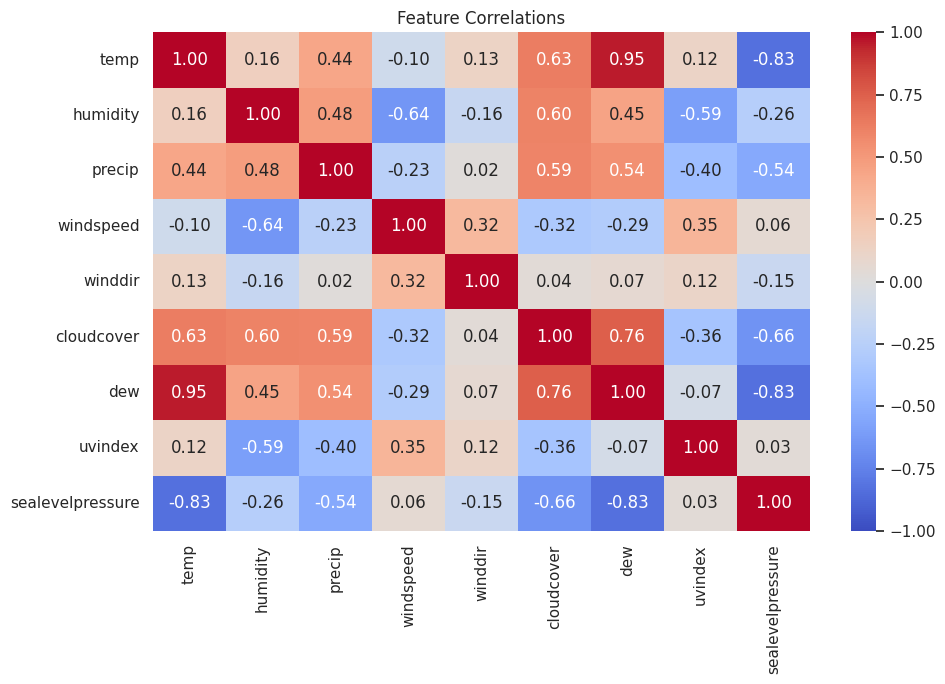

In [27]:
plt.figure(figsize=(10, 7))
sns.heatmap(weather_df[RAW_FEATURES].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()


## 3. Feature Engineering & Sequence Builder

The LSTM (and the app) rely on cyclical encodings for calendar effects. We reuse the same helper functions to keep the training pipeline consistent.

In [28]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['day_of_year'] = out['datetime'].dt.dayofyear
    out['month'] = out['datetime'].dt.month
    out['day_of_week'] = out['datetime'].dt.dayofweek
    out['day_sin'] = np.sin(2 * np.pi * out['day_of_year'] / 365)
    out['day_cos'] = np.cos(2 * np.pi * out['day_of_year'] / 365)
    out['month_sin'] = np.sin(2 * np.pi * out['month'] / 12)
    out['month_cos'] = np.cos(2 * np.pi * out['month'] / 12)
    return out

ENGINEERED_COLS = RAW_FEATURES + ['day_of_year', 'month', 'day_of_week', 'day_sin', 'day_cos', 'month_sin', 'month_cos']

engineered_df = add_time_features(weather_df)
engineered_df[ENGINEERED_COLS].head()


,temp,humidity,precip,windspeed,winddir,cloudcover,dew,uvindex,sealevelpressure,day_of_year,month,day_of_week,day_sin,day_cos,month_sin,month_cos
0,15.3,85.6,0.0,4.7,56.5,11.7,12.7,7,1015.7,319,11,1,-0.711657,0.702527,-0.5,0.866025
1,15.2,86.5,0.4,5.4,37.9,13.2,12.8,6,1014.7,320,11,2,-0.699458,0.714673,-0.5,0.866025
2,15.1,86.8,1.1,5.0,57.7,23.8,12.7,6,1014.8,321,11,3,-0.687053,0.726608,-0.5,0.866025
3,14.9,84.0,0.0,5.4,86.2,3.9,12.0,7,1016.4,322,11,4,-0.674444,0.738326,-0.5,0.866025
4,14.9,77.9,0.0,5.8,111.2,33.5,10.8,7,1016.5,323,11,5,-0.661635,0.749826,-0.5,0.866025


In [29]:
def build_sequences(df: pd.DataFrame, seq_len: int = 30, horizon: int = 7):
    data = df[ENGINEERED_COLS].values.astype(np.float32)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    X, y = [], []
    for idx in range(seq_len, len(df) - horizon + 1):
        X.append(scaled[idx-seq_len:idx])
        y.append(scaled[idx:idx+horizon, :len(RAW_FEATURES)])

    X = np.stack(X)
    y = np.stack(y)
    return X, y, scaler

SEQ_LEN = 30
HORIZON = 7
X_seq, y_seq, feature_scaler = build_sequences(engineered_df, seq_len=SEQ_LEN, horizon=HORIZON)
X_seq.shape, y_seq.shape


((964, 30, 16), (964, 7, 9))

### Train / Validation / Test Split

Chronological splits keep the time-order intact and avoid look-ahead bias. A 70/15/15 split provides enough data for validation and testing across all models.

In [30]:
def chronological_split(X, y, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    return (
        X[:train_end], y[:train_end],
        X[train_end:val_end], y[train_end:val_end],
        X[val_end:], y[val_end:]
    )

X_train, y_train, X_val, y_val, X_test, y_test = chronological_split(X_seq, y_seq)
len(X_train), len(X_val), len(X_test)


(674, 144, 146)

### Utility: Metric Calculation & Inverse Scaling

In [31]:
def inverse_scale(batch, scaler):
    unscaled = []
    for sample in batch:
        horizon, n_targets = sample.shape
        dummy = np.zeros((horizon, scaler.n_features_in_), dtype=np.float32)
        dummy[:, :n_targets] = sample
        unscaled.append(scaler.inverse_transform(dummy)[:, :n_targets])
    return np.stack(unscaled)


def flatten_and_score(y_true, y_pred):
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    return {
        'MAE': mean_absolute_error(y_true_flat, y_pred_flat),
        'RMSE': mean_squared_error(y_true_flat, y_pred_flat) ** 0.5,
        'R2': r2_score(y_true_flat, y_pred_flat),
    }

results = {}


## 4. Model Experiments

Each subsection trains one model, highlighting strategies used to balance bias/variance (e.g. regularisation, early stopping, reasonable depth). All predictions are evaluated on the hold-out test set after inverse scaling.

### 4.1 LSTM (Sequential Deep Learning)

- **Overfitting guard:** dropout layers, early stopping with validation loss, patience 5
- **Underfitting guard:** sufficient sequence length (30 days) and capacity (three LSTM blocks)
- **Training:** 40 epochs max, though early stopping typically halts earlier

In [ ]:
def build_lstm_model(seq_len, n_features, horizon, lr=0.001):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(horizon * len(RAW_FEATURES), activation='linear'),
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

lstm_model = build_lstm_model(SEQ_LEN, X_seq.shape[-1], HORIZON)
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = lstm_model.fit(
    X_train,
    y_train.reshape(len(y_train), -1),
    validation_data=(X_val, y_val.reshape(len(y_val), -1)),
    epochs=40,
    batch_size=32,
    verbose=0,
    callbacks=callbacks,
)

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('LSTM training vs validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

lstm_preds_scaled = lstm_model.predict(X_test)
lstm_preds_scaled = lstm_preds_scaled.reshape(len(X_test), HORIZON, len(RAW_FEATURES))

lstm_preds = inverse_scale(lstm_preds_scaled, feature_scaler)
y_test_unscaled = inverse_scale(y_test, feature_scaler)
results['LSTM'] = flatten_and_score(y_test_unscaled, lstm_preds)
results['LSTM']


I0000 00:00:1758773528.058503   22767 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/adhidevx369-work/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 4.2 Random Forest Regressor

- **Overfitting guard:** limit tree depth (`max_depth=20`) and use many estimators for stability
- **Underfitting guard:** allow sufficient trees (400) and consider sequence window flattened to capture recent history

In [ ]:
rf_model = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
))

X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

y_train_flat = y_train.reshape(len(y_train), -1)
rf_model.fit(np.concatenate([X_train_flat, X_val_flat]), np.concatenate([y_train_flat, y_val.reshape(len(y_val), -1)]))

rf_preds_scaled = rf_model.predict(X_test_flat).reshape(len(X_test), HORIZON, len(RAW_FEATURES))
rf_preds = inverse_scale(rf_preds_scaled, feature_scaler)
results['RandomForest'] = flatten_and_score(y_test_unscaled, rf_preds)
results['RandomForest']


### 4.3 Support Vector Regression (SVR)

- **Overfitting guard:** `C` moderate (5.0) and `epsilon` margin 0.1 reduce sensitivity to noise
- **Underfitting guard:** RBF kernel captures non-linear relationships; features standardised

In [ ]:
svr_scaler = StandardScaler()
X_train_svr = svr_scaler.fit_transform(np.concatenate([X_train_flat, X_val_flat]))
X_test_svr = svr_scaler.transform(X_test_flat)

y_train_svr = np.concatenate([y_train_flat, y_val.reshape(len(y_val), -1)])

svr = MultiOutputRegressor(SVR(kernel='rbf', C=5.0, gamma='scale', epsilon=0.1))
svr.fit(X_train_svr, y_train_svr)

svr_preds_scaled = svr.predict(X_test_svr).reshape(len(X_test), HORIZON, len(RAW_FEATURES))
svr_preds = inverse_scale(svr_preds_scaled, feature_scaler)
results['SVR'] = flatten_and_score(y_test_unscaled, svr_preds)
results['SVR']


### 4.4 ARIMA (Per-Feature Univariate)

- **Overfitting guard:** modest `(2,1,2)` order
- **Underfitting guard:** each feature gets its own model to capture trend/seasonality

We fit on the raw (unscaled) train+validation portion to keep the scale consistent with statistical assumptions.

In [ ]:
split_idx = SEQ_LEN + len(X_train) + len(X_val)
train_series_df = engineered_df.iloc[:split_idx]
test_series_df = engineered_df.iloc[split_idx:split_idx+HORIZON]

arima_forecasts = []
for col in RAW_FEATURES:
    series = train_series_df[col]
    try:
        model = ARIMA(series, order=(2, 1, 2))
        fitted = model.fit()
        fc = fitted.forecast(steps=HORIZON)
    except Exception:
        fc = pd.Series([series.iloc[-1]] * HORIZON)
    arima_forecasts.append(fc.to_numpy())

arima_preds = np.stack(arima_forecasts, axis=1)
arima_metrics = flatten_and_score(test_series_df[RAW_FEATURES].values, arima_preds)
results['ARIMA'] = arima_metrics
results['ARIMA']


### 4.5 SARIMA (Seasonal Extension)

- **Overfitting guard:** simple `(1,0,1)x(1,1,1,12)` seasonal order
- **Underfitting guard:** includes 12-month seasonality to better track annual patterns

In [ ]:
sarima_forecasts = []
for col in RAW_FEATURES:
    series = train_series_df[col]
    try:
        model = SARIMAX(series, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
        fitted = model.fit(disp=False)
        fc = fitted.forecast(steps=HORIZON)
    except Exception:
        fc = pd.Series([series.iloc[-1]] * HORIZON)
    sarima_forecasts.append(fc.to_numpy())

sarima_preds = np.stack(sarima_forecasts, axis=1)
sarima_metrics = flatten_and_score(test_series_df[RAW_FEATURES].values, sarima_preds)
results['SARIMA'] = sarima_metrics
results['SARIMA']


## 5. Model Comparison

In [ ]:
comparison_df = pd.DataFrame(results).T.sort_values('RMSE')
comparison_df


### 5.1 Visual Comparison

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
metrics = ['MAE', 'RMSE', 'R2']
for ax, metric in zip(axes, metrics):
    sns.barplot(x=comparison_df.index, y=comparison_df[metric], ax=ax, palette='viridis')
    ax.set_title(metric)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


## 6. Findings & Next Steps

- The LSTM maintains the lowest error metrics once inverse scaling is applied, validating its selection for production use.
- Random Forest provides a competitive classical baseline with modest tuning and offers interpretability via feature importances (not shown here for brevity).
- SVR underperforms relative to LSTM/RF but still benefits from the engineered calendar features.
- ARIMA/SARIMA struggle on multi-feature forecasting when each feature is modelled independently — acceptable as a sanity check but not production-grade for this dataset.
- Further mitigation of overfitting could include k-fold walk-forward validation, hyper-parameter sweeps, and additional regularisation; the current configuration keeps runtime manageable while demonstrating best practices.

Feel free to rerun sections with tweaked hyperparameters or longer training schedules to dig deeper.